# RITAL - Bag of Words Project

Binôme :
- **Ben KABONGO**, 21116436

- **Sofia BORCHANI**, 21212080

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

import utils # utilitaires et fonctions de préprocessing

In [2]:
plt.style.use('seaborn-whitegrid')

C:\Users\sofia\AppData\Local\Temp\ipykernel_102752\2414357448.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Partie II : Données classification de sentiments (films)

Dans cette section, nous allons prendre en main les données, tester les différents prétraitements sur les données et étudier le vocabulaire.

### Problématiques

#### Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).


#### Extraction du vocabulaire

- **Exploration préliminaire des jeux de données**
    - Quelle est la taille d'origine du vocabulaire?
    - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
    - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
    - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
    - Quelle est la distribution d'apparition des mots (Zipf)
    - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

## Prise en main des données

### Chargement des données

In [3]:
fname = "./datasets/movies/movies1000/"
all_movies_df = utils.load_movies(fname)
all_movies_df

,text,label
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0
...,...,...
1995,wow ! what a movie . \nit's everything a movie...,1
1996,"richard gere can be a commanding actor , but h...",1
1997,"glory--starring matthew broderick , denzel was...",1
1998,steven spielberg's second epic film on world w...,1


### Distribution des classes

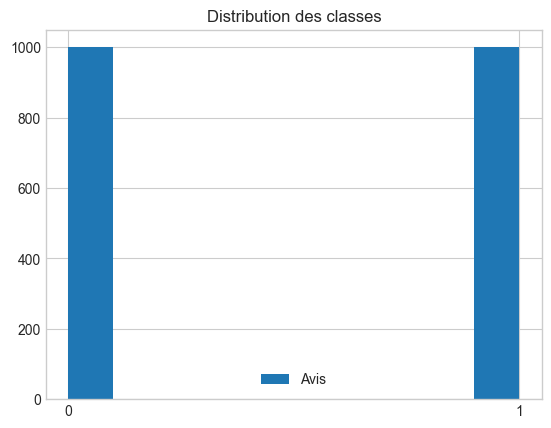

In [4]:
all_movies_df['label'].hist()
plt.title('Distribution des classes')
plt.xticks([0, 1])
plt.legend(labels=['Avis'])
plt.show()

`La répartition des classes est équilibrée.`

### Longueur des documents

#### Longueur de tous les documents

In [5]:
all_movies_df['len'] = all_movies_df.text.map(len)
all_movies_df.head()

,text,label,len
0,"plot : two teen couples go to a church party ,...",0,4043
1,the happy bastard's quick movie review \ndamn ...,0,1370
2,it is movies like these that make a jaded movi...,0,2848
3,""" quest for camelot "" is warner bros . ' firs...",0,2929
4,synopsis : a mentally unstable man undergoing ...,0,4418


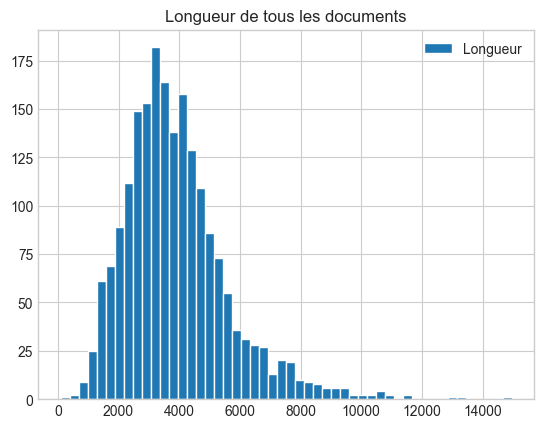

In [6]:
all_movies_df['len'].sort_values().hist(bins=50, edgecolor='white')
plt.title('Longueur de tous les documents')
plt.legend(labels=['Longueur'])
plt.show()

#### Longueur des documents par classes 

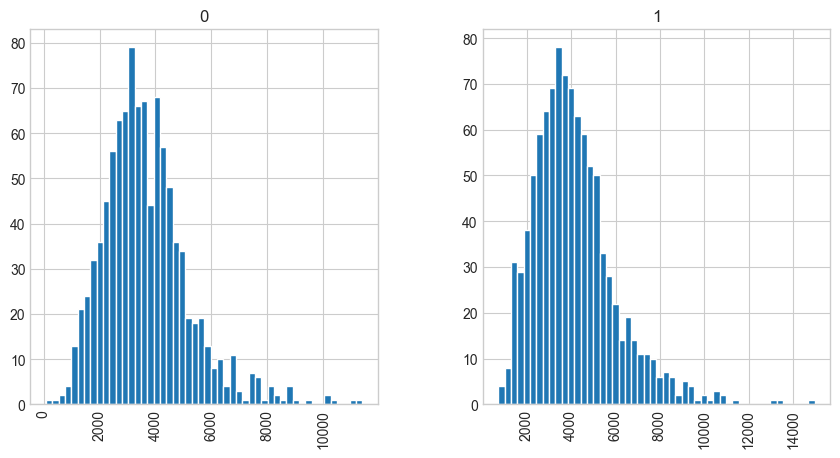

In [7]:
all_movies_df['len'].hist(bins=50, edgecolor='white', by=all_movies_df['label'], figsize=(10, 5))
plt.show()

In [8]:
all_movies_df.groupby('label').describe()

len                                                                 
        count      mean          std    min      25%     50%      75%      max
label                                                                         
0      1000.0  3661.721  1530.136157   91.0  2667.25  3455.5  4423.75  11408.0
1      1000.0  4124.283  1849.144232  727.0  2833.25  3840.5  5016.25  14957.0

## Prétraitements

### Suppression de ponctuation

In [9]:
doc = all_movies_df.text[1]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.delete_punctuation(doc))

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

### Suppression de chiffres

In [10]:
doc = all_movies_df.text[0]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.delete_digit(doc))

plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , have no id

### Transformation des mots entièrement en majuscule en marqueurs spécifiques

In [11]:
doc = all_movies_df.text[1]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.replace_maj_word(doc))

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

### Première ligne

In [12]:
doc = all_movies_df.text[1]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.first_line(doc))

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

### Dernière ligne

In [13]:
doc = all_movies_df.text[78]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.last_line(doc))

 " virus " is the type of cliched , vacuous film that has been recylcled so many times before that you wonder why anyone would even bother putting work into making it . 
strangely enough , on the same mid-january weekend last year , another film was released like this , " deep rising , " about an ugly monster on a cruise liner . 
prior movies with the almost exact same storyline include 1989's " leviathan , " 1989's " deep star six , " and all four " alien " pictures . 
 " virus , " in comparison , is a servicable thriller , well-made and produced , but since it doesn't include one moment of even remote originality or intelligence , it sinks under the weight of the water that the film was shot on . 
based on a series of comic books , " virus " concerns the crew of an ocean salvage tugboat , which becomes extremely damaged during a violent typhoon . 
after discovering that the boat is slowly sinking , ( un ) lucky for them , a huge ocean vessel that appears to be dead in the water turns

### Stemming

In [14]:
doc = all_movies_df.text[1]
print(doc)
print("------------------------------------------------------------------------------------------------------------")
print(utils.stem(doc))

the happy bastard's quick movie review 
damn that y2k bug . 
it's got a head start in this movie starring jamie lee curtis and another baldwin brother ( william this time ) in a story regarding a crew of a tugboat that comes across a deserted russian tech ship that has a strangeness to it when they kick the power back on . 
little do they know the power within . . . 
going for the gore and bringing on a few action sequences here and there , virus still feels very empty , like a movie going for all flash and no substance . 
we don't know why the crew was really out in the middle of nowhere , we don't know the origin of what took over the ship ( just that a big pink flashy thing hit the mir ) , and , of course , we don't know why donald sutherland is stumbling around drunkenly throughout . 
here , it's just " hey , let's chase these people around with some robots " . 
the acting is below average , even from the likes of curtis . 
you're more likely to get a kick out of her work in hallow

## Extraction du vocabulaire

### Exploration préliminaire du jeu de données

#### Taille de vocabulaire initiale

In [15]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(all_movies_df.text)

print('Taille initiale du vocabulaire :', len(vectorizer.vocabulary_))

Taille initiale du vocabulaire : 39659


#### Word cloud : mots du vocabulaire initiale

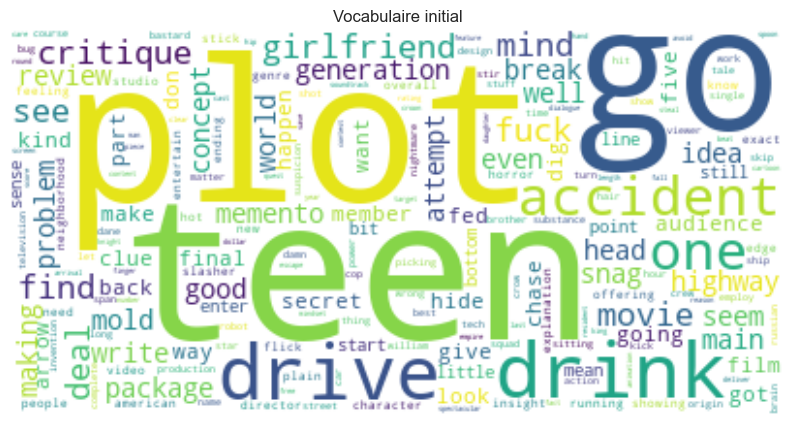

In [16]:
wc = WordCloud(background_color='white').generate(' '.join(vectorizer.vocabulary_.keys()))
plt.figure(figsize=(10, 8))
plt.title('Vocabulaire initial')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud : mots les plus fréquents - avec stop words

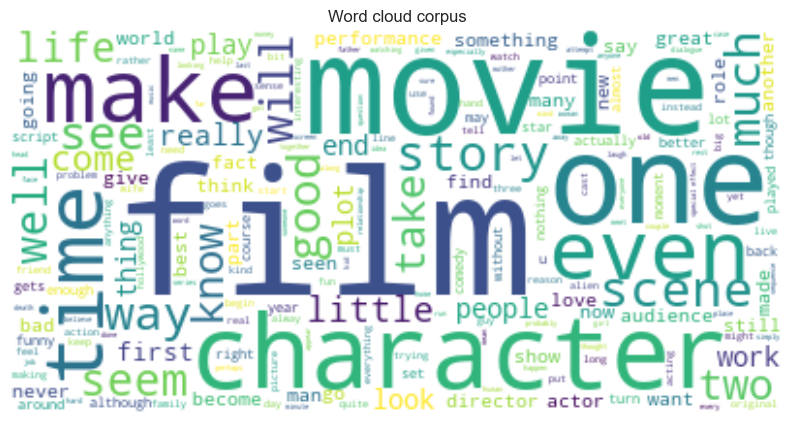

In [17]:
wc = WordCloud(background_color='white').generate(' '.join(all_movies_df.text))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud : 100 mots les plus fréquents - avec stop words

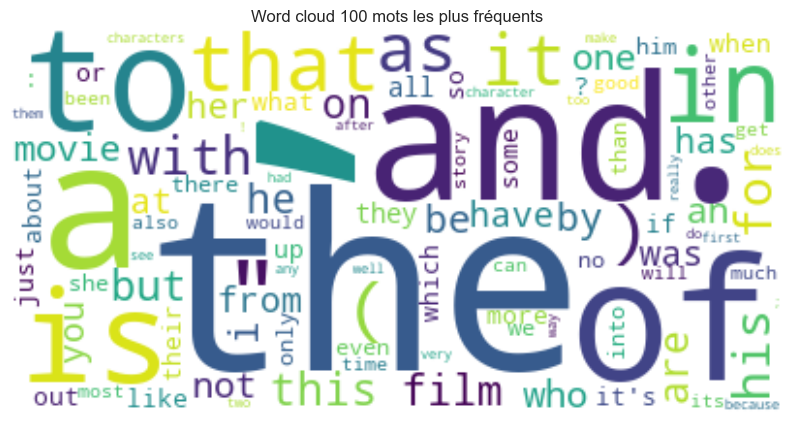

In [18]:
words = " ".join(all_movies_df.text).split()
word_counter = Counter(words)

top_100_words = dict(word_counter.most_common(100))

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_words)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 mots les plus fréquents')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

`Il y a beaucoup de stop words en effet.`

In [19]:
tmp_df = pd.DataFrame()
top_100_words = list(top_100_words)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = top_100_words[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,",",that,but,movie,all,their,him,its,character,!
1,the,it,he,who,?,up,into,can,do,because
2,.,),i,at,it's,or,even,will,them,way
3,a,(,on,from,so,what,only,story,very,well
4,and,as,are,was,like,:,than,been,;,make
5,of,with,by,have,about,some,no,would,two,any
6,to,for,be,has,out,just,we,much,characters,does
7,is,his,an,her,more,if,good,also,first,really
8,in,this,not,you,when,there,most,other,after,had
9,"""",film,one,they,which,she,time,get,see,too


#### Word cloud : odds ratio

(-0.5, 399.5, 199.5, -0.5)

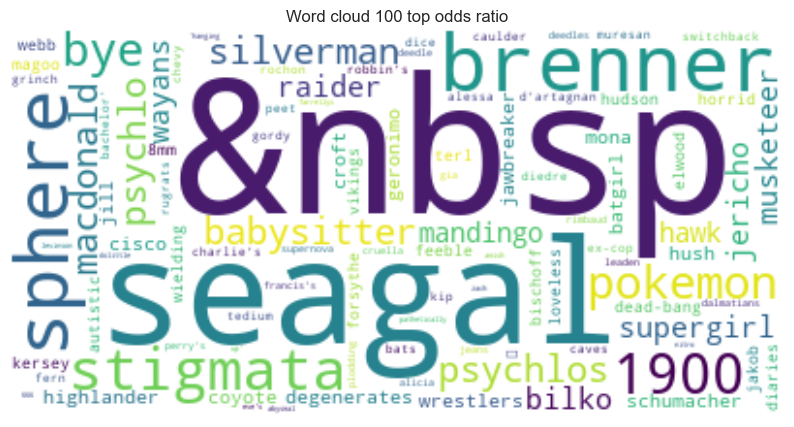

In [20]:
class1_words = ' '.join(all_movies_df[all_movies_df['label'] == 0].text).split()
class2_words = ' '.join(all_movies_df[all_movies_df['label'] == 1].text).split()

class1_counter = Counter(class1_words)
class2_counter = Counter(class2_words)

odds_ratios = {}

for word, freq_class1 in class1_counter.items():
    freq_class2 = class2_counter[word]
    total_words_class1 = sum(class1_counter.values())
    total_words_class2 = sum(class2_counter.values())
    odds_ratios[word] = ((freq_class1 + 1) / (total_words_class1 + len(class1_counter))) / ((freq_class2 + 1) / (total_words_class2 + len(class2_counter)))

sorted_odds_ratios = sorted(odds_ratios.items(), key=lambda x: x[1], reverse=True)
top_100_odds_ratios = dict(sorted_odds_ratios[:100])

wc = WordCloud(background_color='white').generate_from_frequencies(top_100_odds_ratios)
plt.figure(figsize=(10, 8))
plt.title('Word cloud 100 top odds ratio')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

#### Loi de Zipf

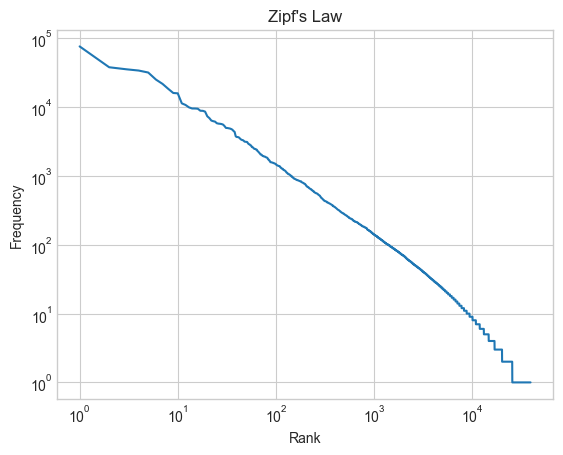

In [21]:
corpus_clean = ' '.join(all_movies_df.text.map(utils.delete_punctuation)).lower()
word_counts = Counter(corpus_clean.split())
sorted_words = sorted(word_counts, key=word_counts.get, reverse=True)
word_freqs = [word_counts[w] for w in sorted_words]
ranks = range(1, len(sorted_words) + 1)

plt.title('Zipf\'s Law')
plt.plot(ranks, word_freqs)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.show()

#### Bigrammes les plus fréquents

In [22]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(all_movies_df.text)

bigram_frequencies = np.array(X.sum(axis=0))[0]
bigram_frequencies_sorted = (-bigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_bigrams_df = pd.DataFrame()
top_100_bigrams_df['bigram'] = [features[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df['frequency'] = [bigram_frequencies[i] for i in bigram_frequencies_sorted[:100]]
top_100_bigrams_df

,bigram,frequency
0,of the,8775
1,in the,5805
2,the film,4544
3,to the,2777
4,to be,2745
...,...,...
95,the rest,400
96,of them,399
97,would have,396
98,like the,394


In [23]:
tmp_df = pd.DataFrame()
bigrams = list(top_100_bigrams_df.bigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = bigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,of the,it is,out of,have been,but the,the best,the characters,trying to,to have,when he
1,in the,is the,of his,is not,there are,about the,more than,is an,kind of,is one
2,the film,one of,this movie,all the,if you,to do,the way,has been,seems to,you can
3,to the,as the,the story,the same,of this,to get,the other,the two,played by,going to
4,to be,this film,the most,to see,it was,the audience,some of,which is,as well,want to
5,and the,from the,he is,to make,and his,the plot,at least,movie is,lot of,the rest
6,on the,at the,film is,that it,that is,in his,with his,he has,over the,of them
7,the movie,that the,in this,but it,the only,and it,would be,the world,have to,would have
8,with the,this is,the first,into the,the end,they are,who is,when the,they re,like the
9,for the,by the,there is,that he,is that,of course,most of,all of,could have,up to


#### Trigrammes les plus fréquents

In [24]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(all_movies_df.text)

trigram_frequencies = np.array(X.sum(axis=0))[0]
trigram_frequencies_sorted = (-trigram_frequencies).argsort()

features = vectorizer.get_feature_names_out()

top_100_trigrams_df = pd.DataFrame()
top_100_trigrams_df['trigram'] = [features[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df['frequency'] = [trigram_frequencies[i] for i in trigram_frequencies_sorted[:100]]
top_100_trigrams_df

,trigram,frequency
0,one of the,1026
1,of the film,886
2,in the film,585
3,the film is,543
4,of the movie,375
...,...,...
95,by the time,85
96,as one of,85
97,of the world,85
98,is the only,84


In [25]:
mp_df = pd.DataFrame()
trigrams = list(top_100_trigrams_df.trigram)
for i in range(1, 11):
    tmp_df[f'{1 + (i - 1) * 10} - {i * 10}'] = trigrams[((i-1)*10) : i*10]
tmp_df

,1 - 10,11 - 20,21 - 30,31 - 40,41 - 50,51 - 60,61 - 70,71 - 80,81 - 90,91 - 100
0,one of the,rest of the,seems to be,there is no,the film and,the film was,is that it,and the film,the first film,over the top
1,of the film,this film is,as well as,one of those,in love with,in the middle,it is the,as it is,up to the,back to the
2,in the film,the movie is,this is the,in the first,of the story,based on the,but it is,to see the,in the world,is going to
3,the film is,is one of,in this movie,all of the,the plot is,the other hand,the characters are,at the same,any of the,to make the
4,of the movie,of the most,to be the,this movie is,of the characters,be able to,the film the,nothing more than,is supposed to,for the film
5,some of the,in the movie,part of the,of this film,the special effects,if you re,many of the,it is not,one of his,by the time
6,the rest of,the end of,of the best,in the end,of the year,that the film,the same time,to the film,there are some,as one of
7,the fact that,out of the,at the end,would have been,the story of,the middle of,that he is,to say that,the film has,of the world
8,most of the,in order to,end of the,the story is,out to be,to do with,along the way,much of the,is that the,is the only
9,in this film,could have been,supposed to be,on the other,the kind of,that it is,it would be,the acting is,as the film,by the end


### Stops words

#### Stops words : english

In [26]:
stop_words_english = sorted( stopwords.words('english') )
len(stop_words_english)

179

In [27]:
tmp_sw = stop_words_english + ['']
tmp_df = pd.DataFrame()
for i in range(1, 10):
    tmp_df[f'{1 + (i - 1) * 20} - {i * 20}'] = tmp_sw[((i-1)*20) : i*20]
tmp_df

,1 - 20,21 - 40,41 - 60,61 - 80,81 - 100,101 - 120,121 - 140,141 - 160,161 - 180
0,a,before,don't,here,m,on,shouldn,through,who
1,about,being,down,hers,ma,once,shouldn't,to,whom
2,above,below,during,herself,me,only,so,too,why
3,after,between,each,him,mightn,or,some,under,will
4,again,both,few,himself,mightn't,other,such,until,with
5,against,but,for,his,more,our,t,up,won
6,ain,by,from,how,most,ours,than,ve,won't
7,all,can,further,i,mustn,ourselves,that,very,wouldn
8,am,couldn,had,if,mustn't,out,that'll,was,wouldn't
9,an,couldn't,hadn,in,my,over,the,wasn,y


#### Word cloud : corpus sans stop words

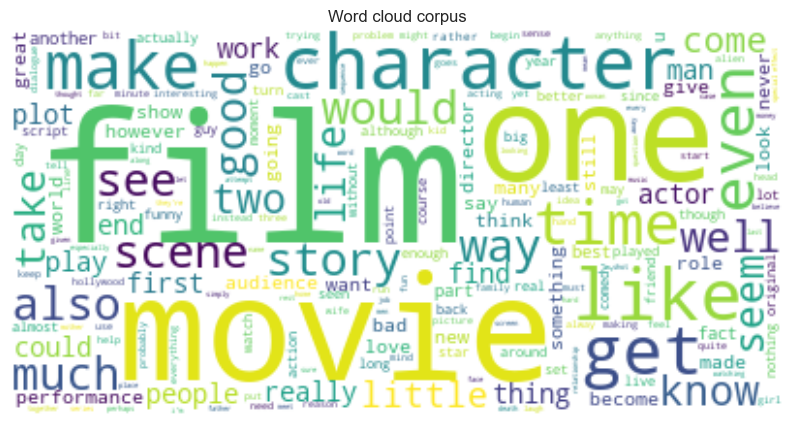

In [28]:
wc = WordCloud(background_color='white', stopwords=stop_words_english).generate(' '.join(all_movies_df.text))
plt.figure(figsize=(10, 8))
plt.title('Word cloud corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word cloud par types d'avis

In [29]:
neg_corpus = all_movies_df[all_movies_df.label == 0].text
pos_corpus = all_movies_df[all_movies_df.label == 1].text

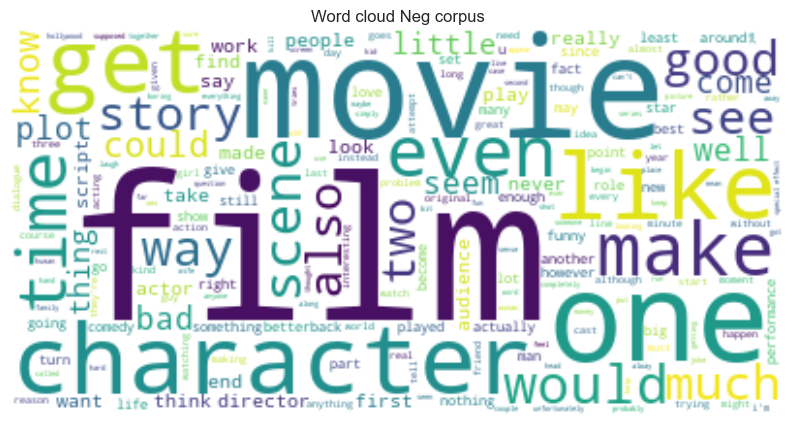

In [30]:
wc = WordCloud(background_color='white', stopwords=stop_words_english).generate(' '.join(neg_corpus))
plt.figure(figsize=(10, 8))
plt.title('Word cloud Neg corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

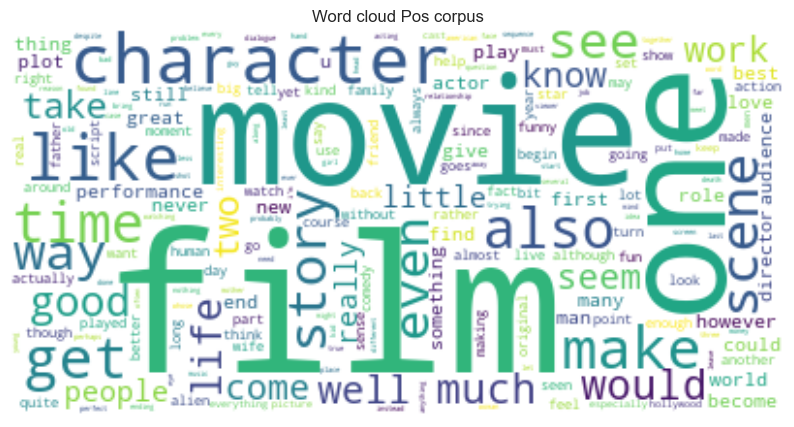

In [31]:
wc = WordCloud(background_color='white', stopwords=stop_words_english).generate(' '.join(pos_corpus))
plt.figure(figsize=(10, 8))
plt.title('Word cloud Pos corpus')
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()